In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
gtf_clip_db = pd.read_csv(
    # "../clip/HepG2.tsv", sep="\t")
    "../clip/K562.tsv", sep="\t")

In [3]:
gtf_clip_db.head()

,rbp,gene_id,transcript_id,gene_name,region,chr,strand,region_start,region_stop,rbp_genomic_start,rbp_genomic_stop,rbp_transcriptomic_start,rbp_transcriptomic_stop,log2(fold-enrichment),-log10(p-value)
0,DDX42,ENSG00000112715,ENST00000497139,VEGFA,transcript,+,6,43777720,43786439,43778070,43778119,351,400,3.226117,7.336035
1,DDX55,ENSG00000157778,ENST00000288607,PSMG3,three_prime_utr,-,7,1567330,1567697,1567475,1567569,146,240,3.325671,5.043274
2,DDX55,ENSG00000157778,ENST00000404674,PSMG3,three_prime_utr,-,7,1567351,1567697,1567475,1567569,125,219,3.325671,5.043274
3,DDX55,ENSG00000157778,ENST00000288607,PSMG3,transcript,-,7,1567330,1569993,1567475,1567569,146,240,3.325671,5.043274
4,DDX55,ENSG00000157778,ENST00000404674,PSMG3,transcript,-,7,1567351,1570045,1567475,1567569,125,219,3.325671,5.043274


In [4]:
gtf_clip_db = gtf_clip_db.loc[gtf_clip_db["region"] != "transcript"]

In [5]:
rna22_table = pd.read_csv(
    # "../rna22/HepG2_rna22_gtf_clip.tsv",
    # "../rna22/K562_rna22_gtf_clip.tsv",
    "../rna22/rna22_energy_pvalue_seed.tsv",
    header=None, sep="\t"
)
rna22_table.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,hsa_let_7a_2_3p,ENSG00000171824_ENST00000304457_1_-1,SEQ_FROM_2213_2236,0,test.seq,-23.5,GGAACAGGCAAAGGAGGCGTGCAA,CTGTACAGCCTCCTAGCTTTCC,((((..(((..((((((((((((.,.))))).))))))).))))))),19,19,24,0,0,0.009810,cDNA
1,hsa_let_7a_2_3p,ENSG00000163435_ENST00000359651_1_1,SEQ_FROM_3113_3133,0,test.seq,-17.6,AGAGTAGCTGGGAGTGTAAGG,CTGTACAGCCTCCTAGCTTTCC,.(((.(((((((((((((.((,)).))))..)))))))))))).,18,18,21,0,0,0.000496,cDNA
2,hsa_let_7a_2_3p,ENSG00000065135_ENST00000369851_1_1,SEQ_FROM_20150_20170,0,test.seq,-17.6,TGAGTAGCTGGGACTCTACAG,CTGTACAGCCTCCTAGCTTTCC,.(((.((((((((((.(((((,))))).))..))))))))))).,18,18,21,0,0,0.007140,cDNA
3,hsa_let_7a_2_3p,ENSG00000122223_ENST00000368034_1_-1,SEQ_FROM_1774_1793,0,test.seq,-16.5,TGAAAGCCTGGACTGTCCGG,CTGTACAGCCTCCTAGCTTTCC,.((((((..(((((((.(((,))).))))..)))..)))))).,16,16,20,0,0,0.001050,cDNA
4,hsa_let_7a_2_3p,ENSG00000163346_ENST00000368463_1_-1,SEQ_FROM_946_970,0,test.seq,-16.8,GGAAGAGCTTCAGAGCCTGATGCAC,CTGTACAGCCTCCTAGCTTTCC,(((.(((((...(((.(((.((((.,.))))))).)))..)))))))),18,18,25,0,0,0.001700,cDNA


In [6]:
rna22_table = rna22_table[[0, 1, 2, 5, 6, 8, 9, 10, 15]]
    
rna22_table["miRNA"] = rna22_table[0].apply(lambda x: "-".join(x.split("_")))
rna22_table["gene_id"] = rna22_table[1].str.split("_").str[0]
rna22_table["transcript_id"] = rna22_table[1].str.split("_").str[1]
rna22_table["rna22_chr"] = rna22_table[1].str.split("_").str[2]
rna22_table["rna22_strand"] = rna22_table[1].str.split("_").str[3]
rna22_table["rna22_transcriptomic_start"] = rna22_table[2].str.split("_").str[2]
rna22_table["rna22_transcriptomic_stop"] = rna22_table[2].str.split("_").str[3]
rna22_table = rna22_table.rename(columns={
    5: "rna22_binding_score",
    6: "rna22_binding_seq", 
    8: "rna22_mRNA_binding_pattern", 
    9: "rna22_miRNA_binding_pattern",
    10: "rna22_heteroduplex_complementary_number",
    15: "rna22_pvalue"
})

rna22_table = rna22_table[[
    "miRNA",
    "gene_id",
    "transcript_id",
    "rna22_chr",
    "rna22_strand",
    "rna22_transcriptomic_start",
    "rna22_transcriptomic_stop",
    "rna22_binding_score",
    "rna22_pvalue",
    "rna22_binding_seq",
    "rna22_mRNA_binding_pattern",
    "rna22_miRNA_binding_pattern",
    "rna22_heteroduplex_complementary_number"
]]

rna22_table = rna22_table.astype({
    "miRNA": "str",
    "gene_id": "str",
    "transcript_id": "str",
    "rna22_chr": "str",
    "rna22_strand": "str",
    "rna22_transcriptomic_start": "int32",
    "rna22_transcriptomic_stop": "int32",
    "rna22_binding_score": "float32",
    "rna22_pvalue": "float32",
    "rna22_binding_seq": "str",
    "rna22_mRNA_binding_pattern": "str",
    "rna22_miRNA_binding_pattern": "str",
    "rna22_heteroduplex_complementary_number": "int32"
})

rna22_table.head()

,miRNA,gene_id,transcript_id,rna22_chr,rna22_strand,rna22_transcriptomic_start,rna22_transcriptomic_stop,rna22_binding_score,rna22_pvalue,rna22_binding_seq,rna22_mRNA_binding_pattern,rna22_miRNA_binding_pattern,rna22_heteroduplex_complementary_number
0,hsa-let-7a-2-3p,ENSG00000171824,ENST00000304457,1,-1,2213,2236,-23.500000,0.009810,GGAACAGGCAAAGGAGGCGTGCAA,((((..(((..((((((((((((.,.))))).))))))).))))))),19
1,hsa-let-7a-2-3p,ENSG00000163435,ENST00000359651,1,1,3113,3133,-17.600000,0.000496,AGAGTAGCTGGGAGTGTAAGG,.(((.(((((((((((((.((,)).))))..)))))))))))).,18
2,hsa-let-7a-2-3p,ENSG00000065135,ENST00000369851,1,1,20150,20170,-17.600000,0.007140,TGAGTAGCTGGGACTCTACAG,.(((.((((((((((.(((((,))))).))..))))))))))).,18
3,hsa-let-7a-2-3p,ENSG00000122223,ENST00000368034,1,-1,1774,1793,-16.500000,0.001050,TGAAAGCCTGGACTGTCCGG,.((((((..(((((((.(((,))).))))..)))..)))))).,16
4,hsa-let-7a-2-3p,ENSG00000163346,ENST00000368463,1,-1,946,970,-16.799999,0.001700,GGAAGAGCTTCAGAGCCTGATGCAC,(((.(((((...(((.(((.((((.,.))))))).)))..)))))))),18


In [7]:
import numpy as np

def seed_complementary_number(pattern):
    mRNA_pattern, miRNA_pattern = pattern.split(",")
    miRNA_pattern = miRNA_pattern[::-1]
    
    strict_number, lax_number = 0, 0
    for i in range(1, 7):
        if (mRNA_pattern[i] == "(") and (miRNA_pattern[i] == ")"):
            strict_number += 1
        if miRNA_pattern[i] == ")":
            lax_number += 1
    
    return strict_number, lax_number
    
rna22_table["rna22_seed_strict_complementary_number"] = (rna22_table["rna22_mRNA_binding_pattern"] + "," + rna22_table["rna22_miRNA_binding_pattern"]).apply(
    lambda pattern: seed_complementary_number(pattern)[0]
)
rna22_table["rna22_seed_lax_complementary_number"] = (rna22_table["rna22_mRNA_binding_pattern"] + "," + rna22_table["rna22_miRNA_binding_pattern"]).apply(
    lambda pattern: seed_complementary_number(pattern)[1]
)

rna22_table.head()

,miRNA,gene_id,transcript_id,rna22_chr,rna22_strand,rna22_transcriptomic_start,rna22_transcriptomic_stop,rna22_binding_score,rna22_pvalue,rna22_binding_seq,rna22_mRNA_binding_pattern,rna22_miRNA_binding_pattern,rna22_heteroduplex_complementary_number,rna22_seed_strict_complementary_number,rna22_seed_lax_complementary_number
0,hsa-let-7a-2-3p,ENSG00000171824,ENST00000304457,1,-1,2213,2236,-23.500000,0.009810,GGAACAGGCAAAGGAGGCGTGCAA,((((..(((..((((((((((((.,.))))).))))))).))))))),19,4,6
1,hsa-let-7a-2-3p,ENSG00000163435,ENST00000359651,1,1,3113,3133,-17.600000,0.000496,AGAGTAGCTGGGAGTGTAAGG,.(((.(((((((((((((.((,)).))))..)))))))))))).,18,5,6
2,hsa-let-7a-2-3p,ENSG00000065135,ENST00000369851,1,1,20150,20170,-17.600000,0.007140,TGAGTAGCTGGGACTCTACAG,.(((.((((((((((.(((((,))))).))..))))))))))).,18,5,6
3,hsa-let-7a-2-3p,ENSG00000122223,ENST00000368034,1,-1,1774,1793,-16.500000,0.001050,TGAAAGCCTGGACTGTCCGG,.((((((..(((((((.(((,))).))))..)))..)))))).,16,6,6
4,hsa-let-7a-2-3p,ENSG00000163346,ENST00000368463,1,-1,946,970,-16.799999,0.001700,GGAAGAGCTTCAGAGCCTGATGCAC,(((.(((((...(((.(((.((((.,.))))))).)))..)))))))),18,5,6


In [164]:
# homo sapiens genome
file = open("../genome/GRCh38.primary_assembly.genome.fa", "r")
genome = {}


seq = ">chrtest"
chrom = "chrtest"
gene_seq = ""
while seq:
    if seq.startswith(">chr"):
        genome[chrom] = gene_seq
        chrom = seq[1:].rstrip("\n")
        gene_seq = ""
    else:
        gene_seq += seq.rstrip("\n")
        
    seq = next(file, None)
    
genome[chrom] = gene_seq

In [165]:
for chrom in genome:
    print(chrom, len(genome[chrom]), genome[chrom][10000:10010])

chrtest 0 
chr1 248956422 TAACCCTAAC
chr2 242193529 CGTATCCCAC
chr3 198295559 CTAACCCTAA
chr4 190214555 ACCCTAACCC
chr5 181538259 TAACCCTAAC
chr6 170805979 NNNNNNNNNN
chr7 159345973 CTAACCCTAA
chr8 145138636 NNNNNNNNNN
chr9 138394717 TAACCCTAAC
chr10 133797422 CTAACCCTAA
chr11 135086622 NNNNNNNNNN
chr12 133275309 CTAACCCTAA
chr13 114364328 NNNNNNNNNN
chr14 107043718 NNNNNNNNNN
chr15 101991189 NNNNNNNNNN
chr16 90338345 TAACCCTAAC
chr17 83257441 NNNNNNNNNN
chr18 80373285 CCCTAACCCT
chr19 58617616 NNNNNNNNNN
chr20 64444167 NNNNNNNNNN
chr21 46709983 NNNNNNNNNN
chr22 50818468 NNNNNNNNNN
chrX 156040895 CTAACCCTAA
chrY 57227415 CTAACCCTAA
chrM 11482745 TATAAATAGT


In [ ]:
for i, row in rna22_table.head().iterrows():
    print(row["rna22_binding_seq"])
    chrom = "chr" + row["rna22_chr"]
    print(genome[chrom])

In [8]:
print(len((rna22_table["gene_id"] + rna22_table["transcript_id"]).unique()))
print(len((gtf_clip_db["gene_id"] + gtf_clip_db["transcript_id"]).unique()))

35650
66


In [9]:
rna22_tb = rna22_table.groupby(by=["gene_id", "transcript_id"])
clip_tb = gtf_clip_db.groupby(by=["gene_id", "transcript_id"])

In [32]:
intersection_regions = set(tuple(pair) for pair in np.array(rna22_table[["gene_id", "transcript_id"]])) & \
    set(tuple(pair) for pair in np.array(gtf_clip_db[["gene_id", "transcript_id"]]))
miRNA_only_regions = set(tuple(pair) for pair in np.array(rna22_table[["gene_id", "transcript_id"]])) - \
    set(tuple(pair) for pair in np.array(gtf_clip_db[["gene_id", "transcript_id"]]))
rbp_only_regions = set(tuple(pair) for pair in np.array(gtf_clip_db[["gene_id", "transcript_id"]]))  - \
    set(tuple(pair) for pair in np.array(rna22_table[["gene_id", "transcript_id"]]))    

In [33]:
print(len(intersection_regions))
print(len(miRNA_only_regions))
print(len(rbp_only_regions))

36
35614
30


In [11]:
for region in regions:
    # print(region, end=" ")
    # print(len(rna22_tb.get_group(region)), end=" ")
    # print(len(clip_tb.get_group(region)), end="\n")
    pass

In [34]:
rna22_rbp_table = {
    "gene_id": [],
    "transcript_id": [],
    "rna22_chr": [],
    "rna22_strand": [],
    "clip_chr": [],
    "clip_strand": [],
    ######
    "miRNA": [],
    "miRNA_transcriptomic_start": [],
    "miRNA_transcriptomic_stop": [],
    "miRNA_binding_score": [],
    "miRNA_binding_pvalue": [],
    "miRNA_heteroduplex_complementary_number": [],
    "miRNA_seed_strict_complementary_number": [],
    "miRNA_seed_lax_complementary_number": [],
    ######
    "rbp": [],
    "rbp_transcriptomic_start": [],
    "rbp_transcriptomic_stop": [],
    "rbp_genomic_start": [],
    "rbp_genomic_stop": [],
    "rbp_log2(fold-enrichment)": [],
    "rbp_-log10(p-value)": [],
    "distance": [],
}

In [35]:
for region in intersection_regions:
    rna22_group = rna22_tb.get_group(region)
    rbp_group = clip_tb.get_group(region)
    
    # print(region)
    for _, miRNA_cite in rna22_group.iterrows():
        for _, rbp_cite in rbp_group.iterrows():
            miRNA_center = (
                miRNA_cite.loc["rna22_transcriptomic_start"] + \
                miRNA_cite.loc["rna22_transcriptomic_stop"]
            ) / 2
            rbp_center = (
                rbp_cite["rbp_transcriptomic_start"] + \
                rbp_cite["rbp_transcriptomic_stop"]
            ) / 2
            
            distance = ((rbp_center - miRNA_center)**2)**(1 / 2)
            
            rna22_rbp_table["gene_id"].append(
                region[0]
            )
            rna22_rbp_table["transcript_id"].append(
                region[1]
            )
            rna22_rbp_table["rna22_chr"].append(
                miRNA_cite["rna22_chr"]
            )
            rna22_rbp_table["rna22_strand"].append(
                miRNA_cite["rna22_strand"][0]
            )            
            rna22_rbp_table["clip_chr"].append(
                rbp_cite["strand"]
            )
            rna22_rbp_table["clip_strand"].append(
                rbp_cite["chr"]
            )       
            
            rna22_rbp_table["miRNA"].append(
                miRNA_cite["miRNA"]
            )
            rna22_rbp_table["miRNA_transcriptomic_start"].append(
                miRNA_cite["rna22_transcriptomic_start"]
            )
            rna22_rbp_table["miRNA_transcriptomic_stop"].append(
                miRNA_cite["rna22_transcriptomic_stop"]
            )
            rna22_rbp_table["miRNA_binding_score"].append(
                miRNA_cite["rna22_binding_score"]
            )
            rna22_rbp_table["miRNA_binding_pvalue"].append(
                miRNA_cite["rna22_pvalue"]
            )
            rna22_rbp_table["miRNA_heteroduplex_complementary_number"].append(
                miRNA_cite["rna22_heteroduplex_complementary_number"]
            )
            rna22_rbp_table["miRNA_seed_strict_complementary_number"].append(
                miRNA_cite["rna22_seed_strict_complementary_number"]
            )
            rna22_rbp_table["miRNA_seed_lax_complementary_number"].append(
                miRNA_cite["rna22_seed_lax_complementary_number"]
            )
    
            rna22_rbp_table["rbp"].append(
                rbp_cite["rbp"]
            )
            rna22_rbp_table["rbp_transcriptomic_start"].append(
                rbp_cite["rbp_transcriptomic_start"]
            )
            rna22_rbp_table["rbp_transcriptomic_stop"].append(
                rbp_cite["rbp_transcriptomic_stop"]
            )
            rna22_rbp_table["rbp_genomic_start"].append(
                rbp_cite["rbp_genomic_start"]
            )
            rna22_rbp_table["rbp_genomic_stop"].append(
                rbp_cite["rbp_genomic_stop"]
            )
            rna22_rbp_table["rbp_log2(fold-enrichment)"].append(
                rbp_cite["log2(fold-enrichment)"]
            )
            rna22_rbp_table["rbp_-log10(p-value)"].append(
                rbp_cite["-log10(p-value)"]
            )
            rna22_rbp_table["distance"].append(
                distance
            )

In [28]:
rna22_rbp_table = pd.DataFrame(rna22_rbp_table, columns=[
    "gene_id",
    "transcript_id",
    "rna22_chr",
    "rna22_strand",
    "clip_chr",
    "clip_strand",
    "miRNA",
    "miRNA_transcriptomic_start",
    "miRNA_transcriptomic_stop",
    "miRNA_binding_score",
    "miRNA_binding_pvalue",
    "miRNA_heteroduplex_complementary_number",
    "miRNA_seed_strict_complementary_number",
    "miRNA_seed_lax_complementary_number",
    "rbp",
    "rbp_transcriptomic_start",
    "rbp_transcriptomic_stop",
    "rbp_genomic_start",
    "rbp_genomic_stop",
    "rbp_log2(fold-enrichment)",
    "rbp_-log10(p-value)",
    "distance",
])

In [31]:
print(len(rna22_rbp_table))
rna22_rbp_table.to_csv("../process/rna22_clip.tsv", sep="\t", index=None)
rna22_rbp_table.head()

1135


,gene_id,transcript_id,rna22_chr,rna22_strand,clip_chr,clip_strand,miRNA,miRNA_transcriptomic_start,miRNA_transcriptomic_stop,miRNA_binding_score,...,miRNA_seed_strict_complementary_number,miRNA_seed_lax_complementary_number,rbp,rbp_transcriptomic_start,rbp_transcriptomic_stop,rbp_genomic_start,rbp_genomic_stop,rbp_log2(fold-enrichment),rbp_-log10(p-value),distance
0,ENSG00000153560,ENST00000283629,3,-,3,-,hsa-miR-10399-3p,1850,1868,-17.400000,...,6,6,ZC3H11A,156,242,33388491,33388577,3.454593,9.316251,1660.0
1,ENSG00000153560,ENST00000283629,3,-,3,-,hsa-miR-10401-5p,3019,3039,-22.000000,...,6,6,ZC3H11A,156,242,33388491,33388577,3.454593,9.316251,2830.0
2,ENSG00000153560,ENST00000283629,3,-,3,-,hsa-miR-1207-5p,2989,3008,-26.400000,...,6,6,ZC3H11A,156,242,33388491,33388577,3.454593,9.316251,2799.5
3,ENSG00000153560,ENST00000283629,3,-,3,-,hsa-miR-1343-5p,3021,3043,-24.400000,...,6,6,ZC3H11A,156,242,33388491,33388577,3.454593,9.316251,2833.0
4,ENSG00000153560,ENST00000283629,3,-,3,-,hsa-miR-3129-5p,1869,1890,-17.799999,...,6,6,ZC3H11A,156,242,33388491,33388577,3.454593,9.316251,1680.5


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
rna22_rbp_table.head()
rna22_rbp_table.to_csv()

,gene_id,transcript_id,miRNA,miRNA_transcriptomic_start,miRNA_transcriptomic_stop,rbp,rbp_transcriptomic_start,rbp_transcriptomic_stop,distance
0,ENSG00000107581,ENST00000369144,hsa-let-7a-2-3p,881,903,GRWD1,3341,3400,2478.5
1,ENSG00000107581,ENST00000369144,hsa-let-7a-2-3p,1782,1805,GRWD1,3341,3400,1577.0
2,ENSG00000107581,ENST00000369144,hsa-let-7a-2-3p,3530,3551,GRWD1,3341,3400,170.0
3,ENSG00000107581,ENST00000369144,hsa-let-7a-5p,656,677,GRWD1,3341,3400,2704.0
4,ENSG00000107581,ENST00000369144,hsa-let-7a-5p,681,700,GRWD1,3341,3400,2680.0


In [91]:
import re

In [120]:
miRNA_index = rna22_rbp_table["miRNA"].apply(
    lambda miRNA: int(re.findall("[0-9]+", miRNA)[0])
)

condition = (miRNA_index <= 100) & (miRNA_index > 50)

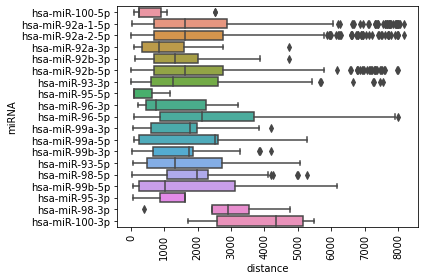

In [121]:
to_plot = rna22_rbp_table.loc[condition]
sns.boxplot(
    data=to_plot,
    y="miRNA",
    x="distance"
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

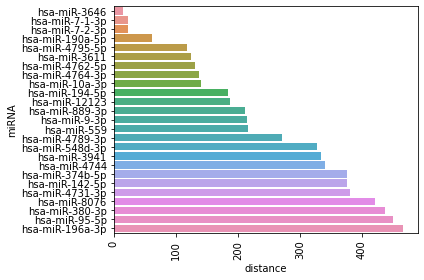

In [133]:
to_plot = rna22_rbp_table.groupby(
    "miRNA"
)[["distance"]].mean().sort_values(by=["distance"])
to_plot = to_plot.iloc[:25]

sns.barplot(
    data=to_plot,
    y=to_plot.index,
    x="distance"
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()